In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
boston = load_boston()
boston_df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])

boston_df['MEDV'] = boston['target']
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

---
# Best Subset Selection

This time around, we would like to use the *best subset selection* algorithm to determine the predictors.

Let's start by writing a helper function for fitting the linear regression which we can then use as part of a loop.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

Now we will write the algorithm associated with **best subset selection**

In [5]:
import itertools
import time

In [6]:
#Initialization variables
Y = boston_df['MEDV']
X = boston_df.drop('MEDV', axis=1)
k = 13
RSS_list, R_squared_list, feature_list = [],[],[]
numb_features = []

#Looping over k = 1 to k = 13 features in X
start = time.perf_counter()
for k in range(1,len(X.columns) + 1):
    
    #Looping over all possible combinations: from 13 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list,
                   'R_squared':R_squared_list,'features':feature_list})

end = time.perf_counter()
print(f"Best Subset Selection Runtime: {end - start:0.4f} seconds")

Best Subset Selection Runtime: 57.7433 seconds


---

### Finding the best subsets for each number of features
Using the smallest RSS value or the largest $R^2$ value, identify the top 5 features from this dataset.

In [7]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(5))
display(df_max.head(5))

,numb_features,RSS,R_squared,features
12,1,19472.381418,0.544146,"(LSTAT,)"
69,2,15439.309201,0.638562,"(RM, LSTAT)"
340,3,13727.985314,0.678624,"(RM, PTRATIO, LSTAT)"
1045,4,13228.907703,0.690308,"(RM, DIS, PTRATIO, LSTAT)"
2276,5,12469.344151,0.708089,"(NOX, RM, DIS, PTRATIO, LSTAT)"


,numb_features,RSS,R_squared,features
12,1,19472.381418,0.544146,"(LSTAT,)"
69,2,15439.309201,0.638562,"(RM, LSTAT)"
340,3,13727.985314,0.678624,"(RM, PTRATIO, LSTAT)"
1045,4,13228.907703,0.690308,"(RM, DIS, PTRATIO, LSTAT)"
2276,5,12469.344151,0.708089,"(NOX, RM, DIS, PTRATIO, LSTAT)"


---

### Adding columns to the dataframe with RSS and $R^2$ values of the best subset

In [8]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,36275.512356,0.150780,"(CRIM,)",19472.381418,0.544146
1,1,37166.558224,0.129921,"(ZN,)",19472.381418,0.544146
2,1,32721.108150,0.233990,"(INDUS,)",19472.381418,0.544146
3,1,41404.216144,0.030716,"(CHAS,)",19472.381418,0.544146
4,1,34916.169908,0.182603,"(NOX,)",19472.381418,0.544146


---

### Plotting the best subset selection process

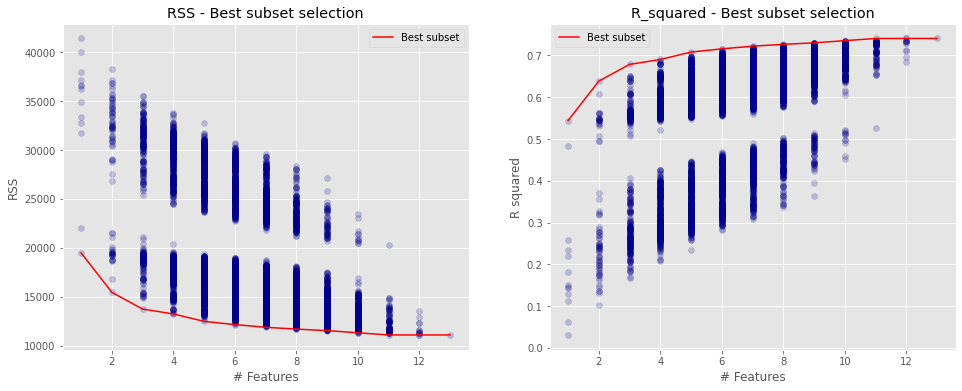

In [9]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

---

# Forward Stepwise Selection
Now we will try the original data with a different algorithm.

In [10]:
#Initialization variables
Y = boston_df['MEDV']
X = boston_df.drop('MEDV', axis=1)
k = 13

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

start = time.perf_counter()
for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

end = time.perf_counter()
print(f"Forward Stepwise Subset Selection Runtime: {end - start:0.4f} seconds")

Forward Stepwise Subset Selection Runtime: 0.8244 seconds


### Displaying results of the first 5 steps

In [11]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,6)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['LSTAT'], 19472),
 (2, ['LSTAT', 'RM'], 15439),
 (3, ['LSTAT', 'RM', 'PTRATIO'], 13728),
 (4, ['LSTAT', 'RM', 'PTRATIO', 'DIS'], 13229),
 (5, ['LSTAT', 'RM', 'PTRATIO', 'DIS', 'NOX'], 12469)]

---

# Comparing models: AIC, BIC, Mallows' $C_p$, and Adjusted $R^2$
The selection methods seem to have an agreement in the first 5 predictors. But how many predictors *should* we use? What are they?

Using the RSS or even the $R^2$ methods are not helpful, as both seem to suggest that all predictors should be used for our model. However, we know that this can lead to overfitting the training data and result in a model with high variance. So we will use the full range of statistics we learned about in Chapter 6 of ISLR.

Recall from Chapter 3 that RSE is the estimate of $\sigma$ and that (3.25) gives us the RSE from a data set with multiple predictors as

\begin{align*}
    \hat{\sigma}^2 = \left( \text{RSE} \right)^2 = \frac{\text{RSS}}{n - p - 1}
\end{align*}


### Combining forward stepwise results into a new DataFrame

In [12]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

### Computing the $C_p$, AIC, BIC and $R^2$ adjusted

In [13]:
#Initializing useful variables
m = len(Y)
p = 13
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[LSTAT],19472.381418,0.544146,1,38.571971,1.712950,1.721303,0.543242
2,"[LSTAT, RM]",15439.309201,0.638562,2,30.690476,1.362940,1.379645,0.637124
3,"[LSTAT, RM, PTRATIO]",13727.985314,0.678624,3,27.397416,1.216697,1.241756,0.676704
4,"[LSTAT, RM, PTRATIO, DIS]",13228.907703,0.690308,4,26.500100,1.176848,1.210260,0.687835
5,"[LSTAT, RM, PTRATIO, DIS, NOX]",12469.344151,0.708089,5,25.087990,1.114138,1.155902,0.705170
6,"[LSTAT, RM, PTRATIO, DIS, NOX, CHAS]",12141.072736,0.715774,6,24.528235,1.089279,1.139396,0.712357
7,"[LSTAT, RM, PTRATIO, DIS, NOX, CHAS, B]",11868.235607,0.722161,7,24.078035,1.069286,1.127756,0.718256
8,"[LSTAT, RM, PTRATIO, DIS, NOX, CHAS, B, ZN]",11678.299470,0.726608,8,23.791670,1.056569,1.123392,0.722207
9,"[LSTAT, RM, PTRATIO, DIS, NOX, CHAS, B, ZN, CRIM]",11583.587544,0.728825,9,23.693496,1.052209,1.127385,0.723905
10,"[LSTAT, RM, PTRATIO, DIS, NOX, CHAS, B, ZN, CR...",11354.983231,0.734177,10,23.330712,1.036098,1.119627,0.728807


In [14]:
df1['R_squared_adj'].idxmax()
df1['R_squared_adj'].max()

0.7348057723274566

---

### Plotting the computed values as a function of number of features

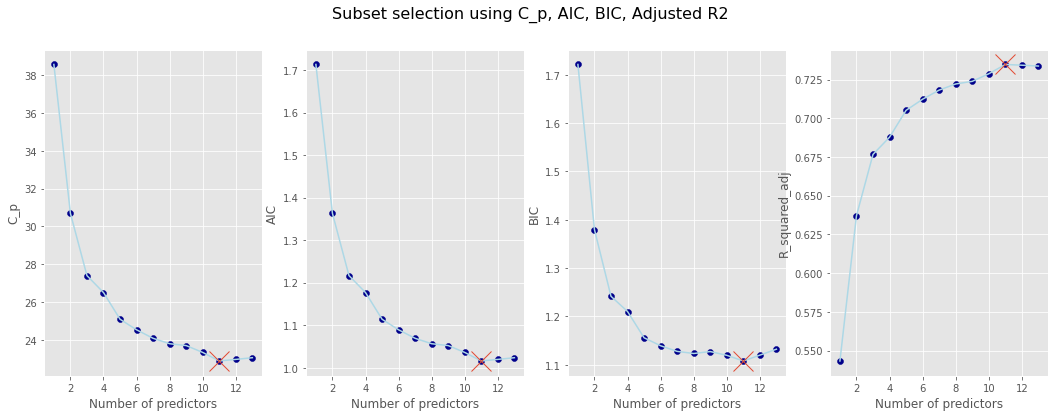

In [15]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()

---

### So what are the features?
We see that every statistic seems to recommend 11 predictors. Let's see what they are.

In [16]:
df1.loc[11].features

['LSTAT',
 'RM',
 'PTRATIO',
 'DIS',
 'NOX',
 'CHAS',
 'B',
 'ZN',
 'CRIM',
 'RAD',
 'TAX']

It seems the model has dropped **AGE**: proportion of owner-occupied units built prior to 1940  
and **INDUS**: proportion of non-retail business acres per town.